In [1]:
import os
import ast
import wfdb
import pywt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.layers import BatchNormalization

2024-03-31 09:59:11.687626: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 09:59:11.687751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 09:59:11.958726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-31 09:59:12.767854: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-31 09:59:18.977708: W tensorflow/compiler/tf2

In [2]:
PATH_TO_DATA = "ptbxl"
ECG_df = pd.read_csv(os.path.join(PATH_TO_DATA, "ptbxl_database.csv"), index_col="ecg_id")
SCP_df = pd.read_csv(os.path.join(PATH_TO_DATA, "scp_statements.csv"), index_col=0)

In [3]:
ECG_df.scp_codes = ECG_df.scp_codes.apply(lambda x : ast.literal_eval(x))
SCP_df = SCP_df[SCP_df.diagnostic == 1]

In [4]:
display(ECG_df.head())

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [5]:
ECG_df_filtered = ECG_df.filter(["ecg_id", "filename_lr", "filename_hr", "scp_codes", "strat_fold"])

In [6]:
ECG_df_filtered

,filename_lr,filename_hr,scp_codes,strat_fold
ecg_id,,,,
1,records100/00000/00001_lr,records500/00000/00001_hr,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",3
2,records100/00000/00002_lr,records500/00000/00002_hr,"{'NORM': 80.0, 'SBRAD': 0.0}",2
3,records100/00000/00003_lr,records500/00000/00003_hr,"{'NORM': 100.0, 'SR': 0.0}",5
4,records100/00000/00004_lr,records500/00000/00004_hr,"{'NORM': 100.0, 'SR': 0.0}",3
5,records100/00000/00005_lr,records500/00000/00005_hr,"{'NORM': 100.0, 'SR': 0.0}",4
...,...,...,...,...
21833,records100/21000/21833_lr,records500/21000/21833_hr,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...",7
21834,records100/21000/21834_lr,records500/21000/21834_hr,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",4
21835,records100/21000/21835_lr,records500/21000/21835_hr,"{'ISCAS': 50.0, 'SR': 0.0}",2


In [7]:
ECG_df_filtered.strat_fold.value_counts()

strat_fold
10    2198
3     2192
9     2183
2     2181
7     2176
1     2175
5     2174
4     2174
8     2173
6     2173
Name: count, dtype: int64

In [8]:
def diagnostic_superclass(scp):
    res = set()
    for k in scp.keys():
        if k in SCP_df.index:
            res.add(SCP_df.loc[k].diagnostic_class)
    return list(res)

In [9]:
ECG_df_filtered['diagnostic_superclass'] = ECG_df_filtered.scp_codes.apply(diagnostic_superclass)

In [10]:
# plot the 

In [11]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data


In [12]:
sampling_rate = 100
ECG_data = load_raw_data(ECG_df_filtered, sampling_rate, PATH_TO_DATA)
ECG_data.shape

(21799, 1000, 12)

In [13]:
ECG_data = np.transpose(ECG_data, (0, 2, 1))
ECG_data.shape

(21799, 12, 1000)

In [14]:
ECG_data[0]

array([[-0.119, -0.116, -0.12 , ...,  0.069,  0.086,  0.022],
       [-0.055, -0.051, -0.044, ...,  0.   ,  0.004, -0.031],
       [ 0.064,  0.065,  0.076, ..., -0.069, -0.081, -0.054],
       ...,
       [-0.026, -0.031, -0.028, ...,  0.024,  0.242,  0.143],
       [-0.039, -0.034, -0.029, ..., -0.041, -0.046, -0.035],
       [-0.079, -0.074, -0.069, ..., -0.058, -0.098, -0.12 ]])

In [15]:
ECG_data[0][0]

array([-0.119, -0.116, -0.12 , -0.117, -0.103, -0.097, -0.119, -0.096,
       -0.048, -0.037, -0.032, -0.002, -0.017, -0.115, -0.156, -0.153,
       -0.143, -0.109, -0.153, -0.178, -0.152,  0.043,  0.469,  0.371,
       -0.002, -0.078, -0.132, -0.132, -0.14 , -0.138, -0.179, -0.18 ,
       -0.119, -0.158, -0.138, -0.117, -0.133, -0.126, -0.149, -0.156,
       -0.139, -0.124, -0.073, -0.078, -0.123, -0.121, -0.062, -0.023,
       -0.024,  0.022,  0.021,  0.011, -0.009, -0.042, -0.048, -0.066,
       -0.088, -0.143, -0.169, -0.17 , -0.19 , -0.184, -0.165, -0.195,
       -0.188, -0.178, -0.186, -0.163, -0.169, -0.138, -0.159, -0.184,
       -0.143, -0.157, -0.126, -0.131, -0.155, -0.143, -0.17 , -0.146,
       -0.157, -0.175, -0.141, -0.158, -0.174, -0.167, -0.168, -0.165,
       -0.158, -0.153, -0.119, -0.113, -0.118, -0.106, -0.149, -0.148,
       -0.132, -0.122, -0.13 , -0.126, -0.051, -0.072, -0.098, -0.081,
       -0.06 , -0.069, -0.106, -0.119, -0.148, -0.129, -0.126, -0.152,
      

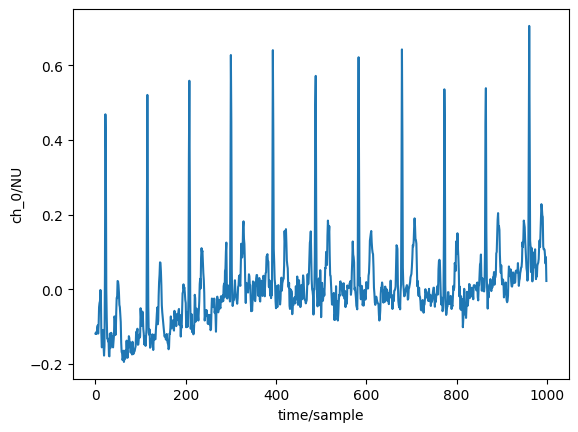

In [16]:
sample = ECG_data[0][0]
wfdb.plot_items(sample)

#### Compute DWT 

In [17]:
def dwt(signal):
    coeffs = pywt.wavedec(signal, wavelet='haar', level=5)
    return np.concatenate(coeffs)


# Iterate over each patient and lead
ECG_data_dwt = []
for patient_data in ECG_data:
    patient_coeffs = []
    for lead_data in patient_data:
        lead_coeffs = dwt(lead_data)
        patient_coeffs.append(lead_coeffs)
    ECG_data_dwt.append(patient_coeffs)

ECG_data_dwt = np.array(ECG_data_dwt)


In [18]:
ECG_data_dwt.shape

(21799, 12, 1002)

In [19]:
Z = pd.DataFrame(0, index=ECG_df_filtered.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    # if len(ECG_df_filtered.loc[i].diagnostic_superclass) == 4:
    #     print(ECG_df_filtered.loc[i].diagnostic_superclass)
    for k in ECG_df_filtered.loc[i].diagnostic_superclass:
        Z.loc[i, k] = 1

Z

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
21833,0,0,1,0,0
21834,1,0,0,0,0
21835,0,0,1,0,0


In [20]:
Z.loc[162]

NORM    0
MI      1
STTC    1
CD      1
HYP     1
Name: 162, dtype: int64

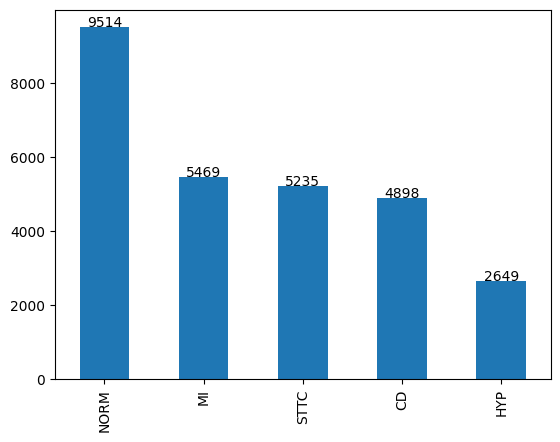

In [21]:
# visualize the number of samples per class
Z.sum().plot(kind='bar')
for i, v in enumerate(Z.sum()):
    plt.text(i, v + 10, str(v), ha='center')

In [47]:
# split the data into X_train and Y_train where ECG_df.strat_fold <= 8

X_train, Y_train = ECG_data[ECG_df.strat_fold <= 8], Z[ECG_df.strat_fold <= 8]
X_valid, Y_valid = ECG_data[ECG_df.strat_fold == 9], Z[ECG_df.strat_fold == 9]
X_test, Y_test = ECG_data[ECG_df.strat_fold == 10], Z[ECG_df.strat_fold == 10]

print("Training set: ", X_train.shape, Y_train.shape)
print("Validation set: ", X_valid.shape, Y_valid.shape)
print("Testing set: ", X_test.shape, Y_test.shape)

Training set:  (17418, 12, 1000) (17418, 2)
Validation set:  (2183, 12, 1000) (2183, 2)
Testing set:  (2198, 12, 1000) (2198, 2)


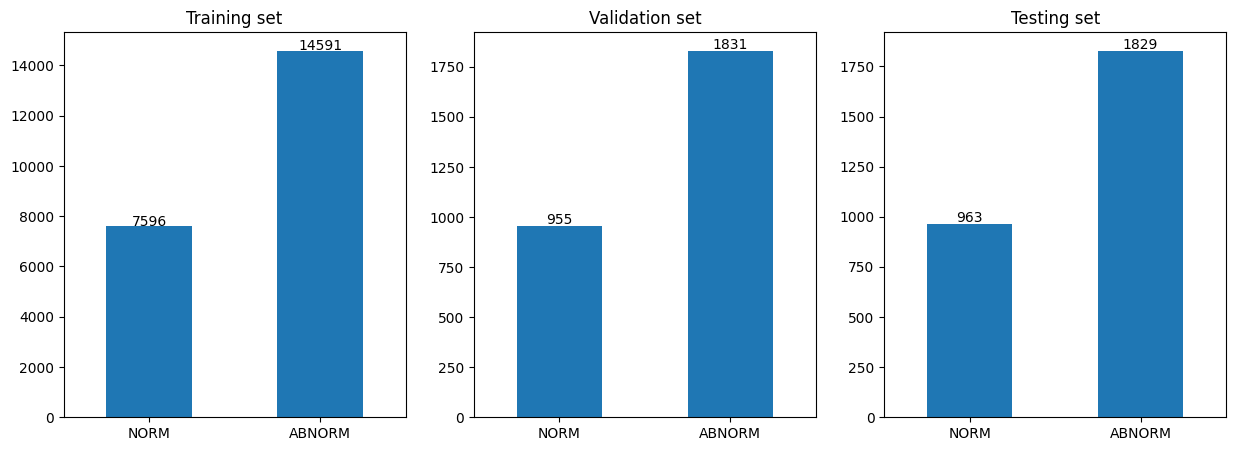

In [48]:
#visualize the number of samples per class in all the three sets in separate plots
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
Y_train.sum().plot(kind='bar')
plt.title('Training set')
plt.xticks(rotation=0)
for i, v in enumerate(Y_train.sum()):
    plt.text(i, v + 10, str(v), ha='center')

plt.subplot(1, 3, 2)
Y_valid.sum().plot(kind='bar')
plt.title('Validation set')
plt.xticks(rotation=0)
for i, v in enumerate(Y_valid.sum()):
    plt.text(i, v + 10, str(v), ha='center')

plt.subplot(1, 3, 3)
Y_test.sum().plot(kind='bar')
plt.title('Testing set')
plt.xticks(rotation=0)
for i, v in enumerate(Y_test.sum()):
    plt.text(i, v + 10, str(v), ha='center')


In [38]:
print(type(X_train))
print(type(Y_train))


<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [49]:
Y_train = Y_train.to_numpy().astype(np.float32)
Y_valid = Y_valid.to_numpy().astype(np.float32)
Y_test = Y_test.to_numpy().astype(np.float32)

In [40]:
print(X_train[0].shape)
print(Y_train[0])

(12, 1002)
[1. 0.]


In [27]:
def build_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(1002, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(1002, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(1002, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model

In [50]:
def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling1D(2),
        Dropout(0.3),
        Conv1D(128, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        Conv1D(256, 3, activation='relu', padding='same'),
        Dropout(0.3),
        GlobalAveragePooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(Z.shape[1], activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics='accuracy')
    return model

In [51]:
model = build_cnn_model((X_train.shape[1], X_train.shape[2]))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 12, 64)            192064    
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 6, 64)             0         
 g1D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 6, 64)             0         
                                                                 
 conv1d_10 (Conv1D)          (None, 6, 128)            24704     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 3, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 3, 256)           

In [52]:
model.fit(X_train, Y_train, epochs=20, batch_size=10, validation_data=(X_valid, Y_valid))

Epoch 1/20


2024-03-31 10:09:18.969240: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 179.33MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-31 10:09:19.022048: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 179.33MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-31 10:09:21.095028: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 156.65MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-31 10:09:21.095086: W external/local_tsl/tsl/framewor

 814/1742 [=============>................] - ETA: 6s - loss: 1516734.5000 - accuracy: 0.5170

KeyboardInterrupt: 

: 

In [ ]:
# get the first lead for training testing and validating
X_train_lead0 = X_train[:, 0, :]
X_valid_lead0 = X_valid[:, 0, :]
X_test_lead0 = X_test[:, 0, :]

In [ ]:
X_train_lead0.shape

(17418, 1002)

In [ ]:
model.fit(X_train_lead0, Y_train, batch_size=10, epochs=50, validation_data=(X_valid_lead0, Y_valid))

Epoch 1/50


2024-03-30 22:30:23.972938: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-30 22:30:30.783672: I external/local_xla/xla/service/service.cc:168] XLA service 0x7374b82fa850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-30 22:30:30.783714: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-03-30 22:30:30.885869: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711818031.149548   21947 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1742/1742 [==============================] - 31s 9ms/step - loss: 185.5459 - accuracy: 0.2803 - val_loss: 286.8649 - val_accuracy: 0.1732
Epoch 2/50
 248/1742 [===>..........................] - ETA: 12s - loss: 956.8148 - accuracy: 0.2278

KeyboardInterrupt: 

In [ ]:
model = Sequential()
model.add(Dense(512, input_dim=1002, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.fit(X_train_lead0, Y_train, batch_size=10, epochs=20, validation_data=(X_valid_lead0, Y_valid))

Epoch 1/20
1742/1742 [==============================] - 8s 4ms/step - loss: 2.2362 - accuracy: 0.3578 - val_loss: 2.0922 - val_accuracy: 0.4544
Epoch 2/20
 889/1742 [==============>...............] - ETA: 2s - loss: 4.1414 - accuracy: 0.2771

KeyboardInterrupt: 

: 